In [1]:
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf
import numpy as np
import optimizer
import sinkhorn_ops
import matplotlib.pyplot as plt
from scipy.misc import imresize
from scipy.optimize import linear_sum_assignment

%matplotlib inline

In [2]:
#Define some ad-hoc merging, splitting and mixing functions

from scipy.special import logsumexp
def sinkhorn(log_alpha, n_iters=20):

    for _ in range(n_iters):
        log_alpha -= logsumexp(log_alpha, axis=1, keepdims=True)
        log_alpha -= logsumexp(log_alpha, axis=0, keepdims=True)
    return np.exp(log_alpha)

def soft_to_hard(soft_perm):
    
    a,b = linear_sum_assignment(-soft_perm)
    ma = np.zeros((np.shape(soft_perm)))
    for i in range(soft_perm.shape[0]):
        ma[i, b[i]] = 1
    return ma


In [3]:
#Define model params
batch_size = 20
n_iter = 200
samples_per_num = 1
n_iter_sinkhorn = 20
noise_factor = 0.0
keep_prob =1.0
opt = 'sgd'
n_units = 5
temp = 0.000000025
lr = 0.001
n_dim = 10

n_numbers = 300

In [4]:
#Main neural network definitions

def create_log_alpha():
    with tf.variable_scope("model_params"):
        random_flattened = tf.reshape(random, [-1, 1])
        net = tf.nn.sigmoid(fc(random_flattened, n_units))
        
        log_alpha =  tf.nn.sigmoid(tf.reshape(fc(net, n_dim, activation_fn=None), [-1, n_numbers, n_dim]))
        sq = tf.reduce_sum(log_alpha **2, axis=2, keepdims=True)
        A = tf.tile(sq, [1, 1, n_numbers])
        B = tf.tile(tf.transpose(sq, [0,2 ,1]), [1, n_numbers, 1])
        C = -2*tf.matmul(log_alpha, tf.transpose(log_alpha, [0, 2, 1]))
        s1 = A+B +C
    with tf.variable_scope("model_params", reuse=True):    
        
        random_flattened2 = tf.reshape(ordered, [-1, 1])
        net2 = tf.nn.sigmoid(fc(random_flattened2, n_units))
        log_alpha2 =  tf.nn.sigmoid(tf.reshape(fc(net2, n_dim, activation_fn=None), [-1, n_numbers, n_dim]))

        sq2 = tf.reduce_sum(log_alpha2 **2, axis=2, keepdims=True)
        A2 = tf.tile(sq2, [1, 1, n_numbers])
        B2 = tf.tile(tf.transpose(sq2, [0,2 ,1]), [1, n_numbers, 1])
        C2 = tf.matmul(-2*log_alpha2, tf.transpose(log_alpha2, [0, 2, 1]))
        s2 = A2+B2 +C2
        
    return s1,s2

def create_log_alphaA():
    with tf.variable_scope("model_paramsA"):
        random_flattenedA = tf.reshape(random, [-1, 1])
        netA = tf.nn.sigmoid(fc(random_flattenedA, n_units))
        
        log_alphaA =  ttf.reshape(fc(netA, n_dim, activation_fn=None), [-1, n_numbers, n_dim])
        sqA = tf.reduce_sum(log_alphaA **2, axis=2, keepdims=True)
        AA = tf.tile(sqA, [1, 1, n_numbers])
        BA = tf.tile(tf.transpose(sqA, [0,2 ,1]), [1, n_numbers, 1])
        CA = -2*tf.matmul(log_alphaA, tf.transpose(log_alphaA, [0, 2, 1]))
        s1A = AA+BA +CA
    with tf.variable_scope("model_paramsA", reuse=True):    
        
        random_flattened2A = tf.reshape(ordered, [-1, 1])
        net2A = tf.nn.sigmoid(fc(random_flattened2A, n_units))
        log_alpha2A =  tf.reshape(fc(net2A, n_dim, activation_fn=None), [-1, n_numbers, n_dim])

        sq2A = tf.reduce_sum(log_alpha2A **2, axis=2, keepdims=True)
        A2A = tf.tile(sq2A, [1, 1, n_numbers])
        B2A = tf.tile(tf.transpose(sq2A, [0,2 ,1]), [1, n_numbers, 1])
        C2A = tf.matmul(-2*log_alpha2A, tf.transpose(log_alpha2A, [0, 2, 1]))
        s2A = A2A+B2A +C2A
        
    return s1A,s2A

In [5]:
#Now we define the main TF variables

random = tf.placeholder(tf.float32,[None, n_numbers])
random_tiled = tf.tile(random, [samples_per_num, 1])


ordered = tf.placeholder(tf.float32,[None, n_numbers])
ordered_tiled = tf.tile(ordered, [samples_per_num, 1])


temperature = tf.constant(temp, dtype=tf.float32)
global_step = tf.Variable(0, trainable=False)
fc = tf.contrib.layers.fully_connected


s1,s2 = create_log_alpha()
f1 = tf.tile(tf.reduce_sum(s1**2, axis=2, keepdims=True),[1, 1, n_numbers]) 
f2 = tf.transpose(tf.tile(tf.reduce_sum(s2**2, axis=2, keepdims=True),[1, 1, n_numbers]), [0, 2 ,1]) 
     
soft_perms_inf = tf.cast(tf.tile(tf.constant(np.eye(n_numbers))[np.newaxis,:,:],[batch_size*samples_per_num, 1, 1]), tf.float32)
for _ in range(5):
    P = tf.reshape(soft_perms_inf, [-1, n_numbers, n_numbers])           
    ma = -1*(f1+f2 - 2*tf.matmul(s1, tf.matmul(P, s2)))
    (soft_perms_inf, _) = sinkhorn_ops.gumbel_sinkhorn(ma, temp, samples_per_num,
                                                                       noise_factor, n_iter_sinkhorn, squeeze=False)

soft_perms_inf1 = tf.cast(tf.tile(tf.constant(np.eye(n_numbers))[np.newaxis,:,:],[batch_size*samples_per_num, 1, 1]), tf.float32)
for _ in range(1):
    P = tf.reshape(soft_perms_inf1, [-1, n_numbers, n_numbers])        
    ma1 = -1*(f1+f2 - 2*tf.matmul(s1, tf.matmul(P, s2)))
    (soft_perms_inf1, _) = sinkhorn_ops.gumbel_sinkhorn(ma1, temp, samples_per_num,
                                                                       noise_factor, n_iter_sinkhorn, squeeze=False)
    

P = tf.reshape(soft_perms_inf, [-1, n_numbers, n_numbers])
l2s_diff = tf.reduce_sum(tf.matmul(P, -ma))   

inv_soft_perms = tf.transpose(soft_perms_inf, [0, 1, 3, 2])
inv_soft_perms_flat = tf.reshape(
  tf.transpose(inv_soft_perms, [1, 0, 2, 3]),
  [-1, n_numbers, n_numbers])

ordered_inf = tf.matmul(inv_soft_perms_flat,  tf.reshape(random_tiled, [-1, n_numbers, 1]))
ordered_tiled = tf.reshape(ordered_tiled, [-1, n_numbers, 1])

# l2s_diff = tf.reduce_mean(
#   tf.square(
#       ordered_tiled - ordered_inf))


P1 = tf.reshape(soft_perms_inf1, [-1, n_numbers, n_numbers])
#l2s_diff = tf.reduce_sum(tf.matmul(P1, -ma1))   

inv_soft_perms1 = tf.transpose(soft_perms_inf1, [0, 1, 3, 2])
inv_soft_perms_flat1 = tf.reshape(
  tf.transpose(inv_soft_perms1, [1, 0, 2, 3]),
  [-1, n_numbers, n_numbers])

ordered_inf1 = tf.matmul(inv_soft_perms_flat1,  tf.reshape(random_tiled, [-1, n_numbers, 1]))


opt = optimizer.set_optimizer(opt, lr, opt_eps=1e-8)
train_op = tf.contrib.training.create_train_op(l2s_diff, opt, global_step=global_step)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [6]:
#Lets train the model

init_op=tf.initialize_all_variables()
sess=tf.InteractiveSession()
sess.run(init_op)
k=1.0
for i in range(n_iter):
    random_np = k*np.random.uniform(0,1,[batch_size, n_numbers])
    random2_np = k*np.random.uniform(0,1,[batch_size, n_numbers])
    
    ordered_np = np.sort(random2_np)
    _,loss=sess.run([train_op,l2s_diff],{random:random_np,
                                             ordered:ordered_np})
    
   
    if i % 50 == 1:
        print('Step %d, Loss: %0.7f' % (i,loss))


Instructions for updating:
Use `tf.global_variables_initializer` instead.
Step 1, Loss: 0.0009753
Step 51, Loss: 0.0007841
Step 101, Loss: 0.0006447
Step 151, Loss: 0.0005572


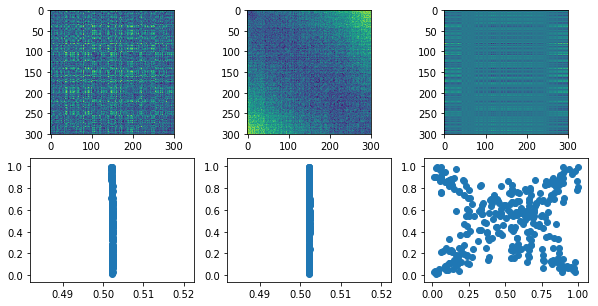

In [7]:
k=1
random_np = k*np.random.uniform(0,1,[batch_size, n_numbers])
ordered_np = np.sort(random_np)
random2_np = k*np.random.uniform(0,1,[batch_size, n_numbers])
ordered2_np = np.sort(random2_np)
[orde,orde1,s1_np,s2_np,sp,f1_np,f2_np,ma_np]=sess.run([ordered_inf,ordered_inf1,s1,s2,soft_perms_inf,f1,f2,ma],{random:random_np,ordered:ordered2_np})
      
P = soft_to_hard(sp[0,0,:,:])
ord3 = np.zeros(n_numbers)
for i in range(n_numbers):
    ord3[np.where(P[i,:]==1)[0][0]] = random_np[0,i]
fig,ax = plt.subplots(2,3,figsize=(10,5))
ax[0,0].imshow(s1_np[0,:,:])
ax[0,1].imshow(s2_np[0,:,:])
ax[0,2].imshow(sp[0,0,:,:])
ax[1,0].scatter(orde1[0,:],ordered_np[0,:])
ax[1,1].scatter(orde[0,:,0], ordered_np[0,:])
ax[1,2].scatter(ord3,ordered_np[0,:])
